# <center>SETTING UP ENVIRONMENT</center>

In [ ]:
is_colab = False
import sys

if "google.colab" in sys.modules:
    print("You are running on Google colab")
    is_colab = True
    from google.colab import drive

    drive.mount('/content/drive')
    drive_url = "/content/drive/MyDrive/LSTM-GRU-data/"
    !pip install --upgrade keras
    !pip install --upgrade tensorflow
else:
    drive_url = ""
    print("You are running on local env")
    is_colab = False


You are running on Google colab
Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import warnings

warnings.filterwarnings("ignore")
from datetime import datetime
from keras.layers import Dense, LSTM, GRU, Embedding, Dropout, Bidirectional, Conv1D, MaxPooling1D, BatchNormalization, Flatten, GlobalMaxPooling1D
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
from keras.metrics import Precision, Recall, F1Score, AUC

from sklearn.model_selection import train_test_split

In [ ]:
dataset_target = "Dataset/"
img_target = "Img/"
model_checkpoint_target = "Model_checkpoint/"
preprocessed_target = "Preprocessed/"
pretrained_target = "Pretrained/"

# <center>DATA PREPARATION</center>

In [ ]:
data = pd.read_csv(drive_url + dataset_target + "cleaned_text_emotion.csv")
# data = data.drop(columns=['Unnamed: 0.1','Unnamed: 0'])
data = data.dropna(subset=['label', 'text'])
data['label'].value_counts()

0    218837
1    165154
Name: label, dtype: int64

In [ ]:
# threshold = 160000
# data = data.groupby('label').apply(lambda x: x.sample(n=min(len(x), threshold)))
# data.reset_index(drop=True, inplace=True)
# data['label'].value_counts()

In [ ]:
# define features & target
texts = data['text']
labels = data['label']
labels = to_categorical(y=labels, num_classes=2)

# split
# Train (90%), Temp(10%)
Xtrain, Xtemp, y_train, y_temp = train_test_split(texts, labels, test_size=0.1, random_state=17)

# Val(8%), Test(2)
Xval, Xtest, y_val, y_test = train_test_split(Xtemp, y_temp, test_size=0.2, random_state=17)

print(f"train size: {len(Xtrain)}")
print(f"dev size: {len(Xval)}")
print(f"test size: {len(Xtest)}")

train size: 345591
dev size: 30720
test size: 7680


# <center>TOKENIZE DATA</center>

In [ ]:
# Get a dictionary contain vocabularies
tokenizer = Tokenizer(num_words=None)  # set None to get the largest as possible
tokenizer.fit_on_texts(Xtrain)

In [ ]:
# Number of tokens
dic_size = len(tokenizer.word_counts.items())
print(f"Total of word: {dic_size} words")

num_tokens = dic_size + 1

Total of word: 35234 words


#<center>VECTORIZE DATA</center>

In [ ]:
seq_X_train = tokenizer.texts_to_sequences(Xtrain)
seq_X_val = tokenizer.texts_to_sequences(Xval)
seq_X_test = tokenizer.texts_to_sequences(Xtest)

In [ ]:
# Max length of the sentence
max_length = np.max(np.array([len(sentence) for sentence in seq_X_train]))
margin = 10
max_length = max_length + margin
max_length

# max_length = 65

145

In [ ]:
# Padding
Xtrain = pad_sequences(sequences=seq_X_train, maxlen=max_length, padding="post")
Xval = pad_sequences(sequences=seq_X_val, maxlen=max_length, padding='post')
Xtest = pad_sequences(sequences=seq_X_test, maxlen=max_length, padding='post')

# <center>LOAD PRETRAIN MODEL: WIKI-NEWS-300D-1M BY FASTTEXT</center>

In [ ]:
# ##### Load pretrained embedding layer
# def load_embedding_model(file: str) -> str:
#     """
#     Load word embeddings from a specified file into a dictionary.

#     This function reads word embeddings from the given file and stores them in a dictionary, with words as keys
#     and their corresponding embeddings as values.

#     Parameters:
#         file (str): The path to the file containing word embeddings.

#     Returns:
#         dict: A dictionary where words are keys, and their embeddings are lists of floats.

#     Example:
#         >>> embedding_model = load_embedding_model("pretrained/wiki-news-300d-1M.vec")
#     """
#     embedding_model = {}
#     with open(file, 'r', encoding='utf-8') as f:
#         for line in f:
#             split_line = line.split()
#             word = split_line[0]
#             embedding = [float(value) for value in split_line[1:]]
#             embedding_model[word] = embedding
#     return embedding_model


# embedding_index_fasttext = load_embedding_model(file=drive_url + pretrained_target + "wiki-news-300d-1M.vec")
# print('found %s word vectors in loaded fasttext model.' % len(embedding_index_fasttext))

In [ ]:
# with open(drive_url+pretrained_target+'embedding_model.pkl', 'wb') as file:
#     pickle.dump(embedding_index_fasttext, file)

In [ ]:
with open(drive_url+pretrained_target+'embedding_model.pkl', 'rb') as file:
    embedding_index_fasttext = pickle.load(file)
    print('found %s word vectors in loaded fasttext model.' % len(embedding_index_fasttext))

found 999995 word vectors in loaded fasttext model.


In [ ]:
##### preparing a corresponding embedding matrix
def embedding_matrix(tokens: int, embedding_dims: int, embedding_index: dict):
    """
    Create an embedding matrix for tokens using pre-trained embeddings.

    This function constructs an embedding matrix for tokens using pre-trained word embeddings. It matches words from the tokenizer's word index with pre-trained embeddings, creating a matrix with the specified dimensions. If a word is not found in the pre-trained embeddings, it is represented by a row of zeros in the matrix.

    Parameters:
        tokens (int): The total number of tokens.
        embedding_dims (int): The dimensionality of the word embeddings.
        embedding_index (dict): A dictionary containing pre-trained word embeddings.

    Returns:
        numpy.ndarray: The embedding matrix.

    Example:
        >>> embedding_mat = embedding_matrix(10000, 300, embedding_index)
        >>> print(embedding_mat.shape)
        (10000, 300)
    """
    hits = 0
    misses = []
    embedding_mat = np.zeros((tokens, embedding_dims))
    for word, i in tokenizer.word_index.items():
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_mat[i] = embedding_vector
            hits += 1

        else:
            misses.append(word)
    print("Converted %d words (%d misses)" % (hits, len(misses)))
    print("words not included in pretrained model:", misses)
    return embedding_matrix

In [ ]:
embedding_dim = 300
embedding_matrix_fasttext = embedding_matrix(num_tokens, embedding_dim, embedding_index_fasttext)
embedding_layer_fasttext = Embedding(
    input_dim=num_tokens,
    output_dim=embedding_dim,
    input_length=max_length,
    trainable=False
)

Converted 27968 words (7266 misses)
words not included in pretrained model: ['listclass', 'hellip', 'languagedirection', 'utf', 'mobileclass', 'nclick', 'stumbleupon', 'getyourprettyon', 'fullnews', 'clearboth', 'allowfullscreen', 'isprivateblog', 'inhalt', 'frameborder', 'gne', 'stic', 'jumbleupon', 'ismobilerequest', 'nanowrimo', 'elia', 'itemprop', 'parlbox', 'bankset', 'neoneun', 'omberok', 'katniss', 'neoreul', 'lmaz', 'alhamdulillah', 'sephora', 'bdm', 'arlovski', 'minine', 'muenchen', 'buttonfixed', 'wiheomhae', 'yapi', 'otd', 'zanne', 'johnnydepp', 'edochie', 'rlitz', 'bram', 'ilina', 'sonipro', 'joong', 'addthis', 'rsswidget', 'failaholic', 'lilongwe', 'ifeeldelicious', 'plusone', 'ticos', 'rhead', 'nuneul', 'arol', 'kaua', 'jaejoong', 'bingen', 'neelima', 'walgreens', 'alignright', 'aligncenter', 'addthisurl', 'squez', 'louboutin', 'funnyhumorcomedyblog', 'draftbloger', 'genevieve', 'itemscope', 'dearwendy', 'honga', 'clarin', 'dling', 'askdoctor', 'gadwojulge', 'lexapro', 't

# <center>STRUCTURE MODEL</center>

In [ ]:
model = Sequential()

model.add(embedding_layer_fasttext)
model.add(Conv1D(128, 6, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax', name="predictions"))

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 145, 300)          10570500  
                                                                 
 conv1d (Conv1D)             (None, 140, 128)          230528    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 predictions (Dense)         (None, 2)                 130       
                                                        

# <center>TRAINING</center>

In [ ]:
model_checkpoint = ModelCheckpoint(filepath=drive_url + model_checkpoint_target + 'sentiment_analysis('+str(datetime.now().strftime("%Y-%m-%d"))+').h5',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)


early_stopping = EarlyStopping(monitor='val_loss', patience=1, mode='min')

metrics = ['accuracy', Precision(), Recall(), F1Score(), AUC()]

metrics_history = {
    "loss": [],
    "accuracy": [],
    "precision": [],
    "recall": [],
    "f1_score": [],
    "auc": []
}


def on_batch_end(batch, logs):
    metrics_history["loss"].append(logs["loss"])
    metrics_history["accuracy"].append(logs["accuracy"])
    metrics_history["precision"].append(logs["precision"])
    metrics_history["recall"].append(logs["recall"])
    metrics_history["f1_score"].append(logs["accuracy"])
    metrics_history["auc"].append(logs["auc"])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(learning_rate=3*(10^-3), epsilon=1*(10^-8)),
              metrics=metrics, run_eagerly=True)

history = model.fit(Xtrain, y_train,
                    epochs=10,
                    batch_size=256,
                    validation_data=(Xval, y_val),
                    callbacks=[early_stopping,
                               model_checkpoint,
                               tf.keras.callbacks.LambdaCallback(on_batch_end=on_batch_end)],
                    shuffle=True)

Epoch 1/10


1350/1350 [==============================] - ETA: 0s - loss: 0.5259 - accuracy: 0.7190 - precision: 0.7190 - recall: 0.7190 - f1_score: 0.7021 - auc: 0.8072
Epoch 1: val_loss improved from inf to 0.23746, saving model to /content/drive/MyDrive/LSTM-GRU-data/Model_checkpoint/sentiment_analysis(2023-10-26).h5
1350/1350 [==============================] - 245s 171ms/step - loss: 0.5259 - accuracy: 0.7190 - precision: 0.7190 - recall: 0.7190 - f1_score: 0.7021 - auc: 0.8072 - val_loss: 0.2375 - val_accuracy: 0.9071 - val_precision: 0.9071 - val_recall: 0.9071 - val_f1_score: 0.9056 - val_auc: 0.9691
Epoch 2/10
1350/1350 [==============================] - ETA: 0s - loss: 0.1718 - accuracy: 0.9355 - precision: 0.9355 - recall: 0.9355 - f1_score: 0.9343 - auc: 0.9816
Epoch 2: val_loss improved from 0.23746 to 0.11784, saving model to /content/drive/MyDrive/LSTM-GRU-data/Model_checkpoint/sentiment_analysis(2023-10-26).h5
1350/1350 [==============================] - 234s 172ms/step - loss: 0.171

# <center>TESTING</center>

In [ ]:
result = model.evaluate(Xtest, y_test)

240/240 [==============================] - 15s 63ms/step - loss: 0.0652 - accuracy: 0.9771 - precision: 0.9771 - recall: 0.9771 - f1_score: 0.9766 - auc: 0.9964


In [ ]:
df = pd.read_csv(drive_url + dataset_target + "real-data.csv", delimiter=";", encoding='ISO-8859-1')
real_Xtest = df['text']
real_Ytest = df['label']
real_Ytest = to_categorical(y=real_Ytest, num_classes=2)

seq_realXtest = tokenizer.texts_to_sequences(real_Xtest)
real_Xtest = pad_sequences(sequences=seq_realXtest, maxlen=max_length, padding="post")

In [ ]:
real_result = model.evaluate(real_Xtest, real_Ytest)

4/4 [==============================] - 1s 319ms/step - loss: 0.7212 - accuracy: 0.8000 - precision: 0.8000 - recall: 0.8000 - f1_score: 0.7997 - auc: 0.8766


# <center>VISUALIZE RESULT</center>

### <center>Over epoch</center>

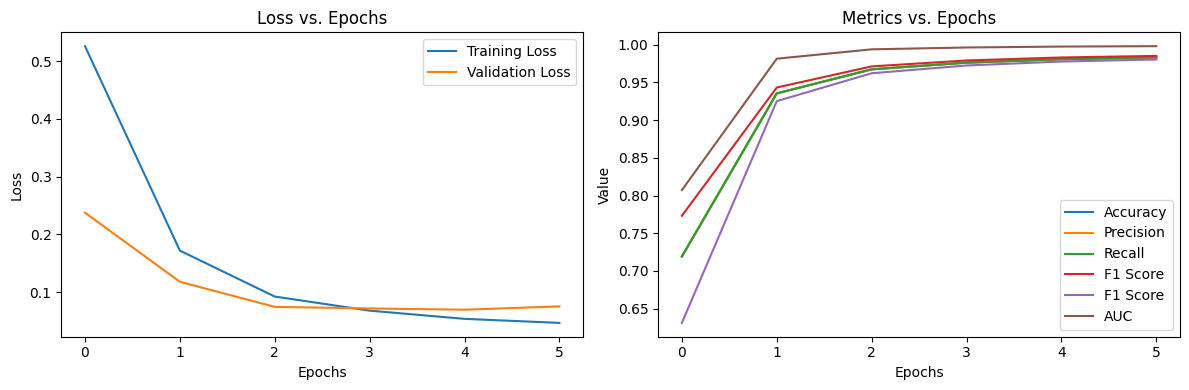

In [ ]:
import matplotlib.pyplot as plt

# Lấy dữ liệu từ history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
accuracy = history.history['accuracy']
precision = history.history['precision']
recall = history.history['recall']
f1 = history.history['f1_score']
auc = history.history['auc']

# loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Accuracy, Precision, Recall, F1_score, AUC on Epoch
plt.subplot(1, 2, 2)
plt.plot(accuracy, label='Accuracy')
plt.plot(precision, label='Precision')
plt.plot(recall, label='Recall')
plt.plot(f1, label='F1 Score')
plt.plot(auc, label='AUC')
plt.legend()
plt.title('Metrics vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Value')

plt.tight_layout()
plt.savefig(drive_url + img_target + 'performance_over_epochs.png')
plt.show()


### <center>Over batch</center>

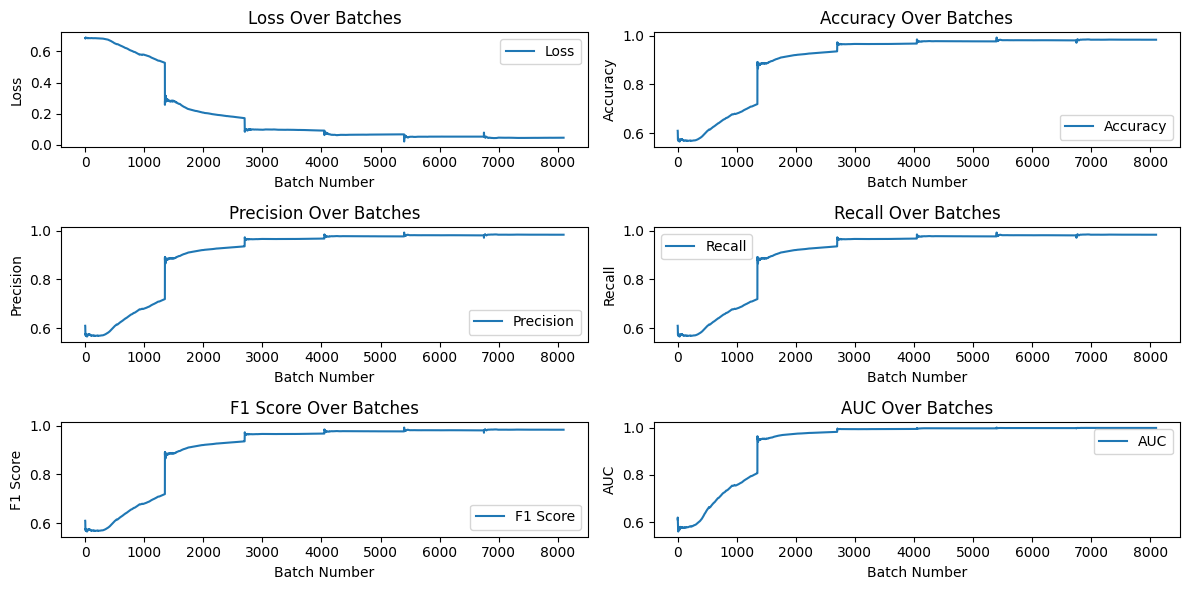

In [ ]:
# loss
plt.figure(figsize=(12, 6))
plt.subplot(3, 2, 1)
plt.plot(metrics_history['loss'], label='Loss')
plt.title('Loss Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Loss')
plt.legend()

# accuracy
plt.subplot(3, 2, 2)
plt.plot(metrics_history['accuracy'], label='Accuracy')
plt.title('Accuracy Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Accuracy')
plt.legend()

# precision
plt.subplot(3, 2, 3)
plt.plot(metrics_history['precision'], label='Precision')
plt.title('Precision Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Precision')
plt.legend()

# recall
plt.subplot(3, 2, 4)
plt.plot(metrics_history['recall'], label='Recall')
plt.title('Recall Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('Recall')
plt.legend()
# plt.show()

# F1-score
plt.subplot(3, 2, 5)
plt.plot(metrics_history['f1_score'], label='F1 Score')
plt.title('F1 Score Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('F1 Score')
plt.legend()
# plt.show()

# AUC
plt.subplot(3, 2, 6)
plt.plot(metrics_history['auc'], label='AUC')
plt.title('AUC Over Batches')
plt.xlabel('Batch Number')
plt.ylabel('AUC')
plt.tight_layout()
plt.legend()
plt.savefig(drive_url + img_target + 'performance_over_batches.png')
plt.show()

# <center>LOAD TRAINED MODEL TO DEPLOY OR PREDICT ON REAL INPUT</center>

*Note: When want to test the model with keyboard's input, run the task below:*
- setting up environment
- data preparation
- data preprocessing
- load preprocessing data
- tokenize data
- vectorize data
- load trained model to deploy or predict on real input*

*important: don't run the task below*
- load pretrain model: wiki-news-300d-1m by fasttext
- structure model
- training
- testing
- visualize result

In [ ]:
# load model
from keras.models import load_model

lstm_gru_model = load_model(drive_url + model_checkpoint_target + 'sentiment_analysis(2023-10-25).h5')

lstm_gru_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 145, 300)          9729900   
                                                                 
 bidirectional (Bidirection  (None, 145, 256)          439296    
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 256)               296448    
 onal)                                                           
                                                                 
 dense (Dense)               (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                2

In [ ]:
np.set_printoptions(threshold=np.inf)


@tf.autograph.experimental.do_not_convert
def prediction(input_sentences: list[str], is_print: bool = False):
    """
    Predict sentiment scores for a list of input sentences.

    This function preprocesses a list of input sentences, tokenizes them, and uses a pre-trained model to predict sentiment scores. It returns a dictionary with input sentences as keys and their respective positive and negative sentiment scores as values.

    Parameters:
        input_sentences (list of str): A list of input sentences to predict sentiment for.
        is_print (bool): If True, the results will be printed to the console. (Default: False)

    Returns:
        dict: A dictionary with input sentences as keys and their respective sentiment scores as values.

    Example:
        >>> input_sentences = ["Unfortunately, the rest of the day was fantastic"]
        >>> sentiment_scores = prediction(input_sentences, is_print=True)
        =======================================
        Input: unfortunately the rest the day fantastic
        Positive score: 19.70%
        Negative score: 80.30%
        =======================================
    """
    results = {}

    for input_sentence in input_sentences:
        # preprocess and tokenizer
        # input_sentence = text_preprocess(input_sentence)
        seq = tokenizer.texts_to_sequences([input_sentence])
        x = pad_sequences(sequences=seq, maxlen=max_length, padding='post')
        # call model to predict
        predictions = lstm_gru_model.predict(x, verbose=0)
        # Get probability of positive
        positive_probabilities = predictions[:, 1]
        # convert to percentage
        positive_percentage = positive_probabilities * 100
        negative_percentage = (1 - positive_probabilities) * 100

        positive_score = positive_percentage[0]
        negative_score = negative_percentage[0]

        results[input_sentence] = (positive_score, negative_score)
    print("=======================================")
    if is_print:
        for sent in results:
            print(f"Input: {sent}")
            print(f"Positive score: {results[sent][0]:.2f}%")
            print(f"Negative score: {results[sent][1]:.2f}%")
            print("=======================================")

    return results


In [ ]:
predicted = prediction(real_Xtest, True)